# Train a RBM model

This notebook woul train a Restricted Boltzmann Machine (RBM) over the MNIST dataset using PySINGA. The RBM model would learn a feature representation of a digit image like MNIST images.
Please refer to the previous two notebooks for basic usages of Tensor and other moduels of PySINGA.

* Please intall Pillow to enable image display. 'conda install pillow'

## Download the training data

We will use a pre-processed version of the original MNIST dataset.

In [1]:
from __future__ import division
from __future__ import print_function
from future import standard_library
standard_library.install_aliases()
standard_library.install_aliases()
from builtins import range
from past.utils import old_div

import numpy as np
import os
import gzip
import argparse
import pickle
import utils
import urllib.request, urllib.parse, urllib.error
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline


def load_train_data():
    # download the data for the first time running
    print('downloading data')
    urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz', 'data.bin')
    print('finished data downloading')
    f = gzip.open('data.bin', 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    traindata = train_set[0].astype(np.float32)
    validdata = valid_set[0].astype(np.float32)
    print(traindata.shape, validdata.shape)
    return traindata, validdata

Import PySINGA modules

In [2]:
from singa import initializer
from singa import optimizer
from singa import device
from singa import tensor

## Setup

* Load training data
* Create the device. If GPU is available, please set **use_gpu=True**
* Create SGD optimzier with given momentum and weight decay
* Create parameter Tensor instances and initialize the parameters

In [3]:
opt = optimizer.SGD(momentum=0.8, weight_decay=0.0002) 

hdim = 1000
vdim = 784
w = tensor.Tensor((vdim, hdim))
w.gaussian(0.0, 0.1)
vb = tensor.from_numpy(np.zeros(vdim, dtype = np.float32))
hb = tensor.from_numpy(np.zeros(hdim, dtype = np.float32))

print('Loading data ..................')
dat,_ = load_train_data()

use_gpu = False
if use_gpu:
    dev = device.create_cuda_gpu()
else:
    dev = device.get_default_device()

for t in [w, vb, hb]:
    t.to_device(dev)

Loading data ..................
downloading data
finished data downloading
(50000, 784) (10000, 784)


Train the RBM model for 10 epochs, for each epoch
* Plot the weight matrix
* Update the model parameters using CD algorithm,
    * Get a mini-batch of training data
    * Do positive phase
    * Do negative phase
    * Compute reconstruction error
    * Compute parameter gradients and update the parameters

Epoch 0, Reconstruction error per image = 17.919702
Epoch 1, Reconstruction error per image = 10.966256
Epoch 2, Reconstruction error per image = 9.598818
Epoch 3, Reconstruction error per image = 8.899601
Epoch 4, Reconstruction error per image = 8.476742
Epoch 5, Reconstruction error per image = 8.188001
Epoch 6, Reconstruction error per image = 7.974924
Epoch 7, Reconstruction error per image = 7.822625
Epoch 8, Reconstruction error per image = 7.691377
Epoch 9, Reconstruction error per image = 7.588384


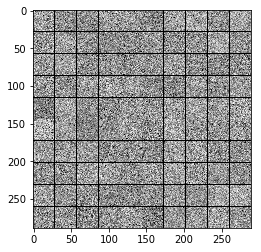

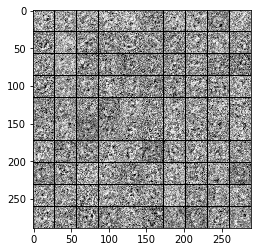

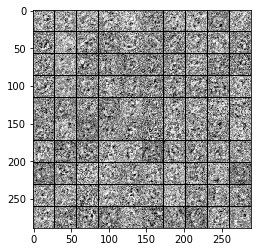

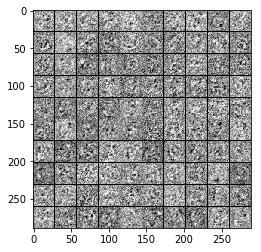

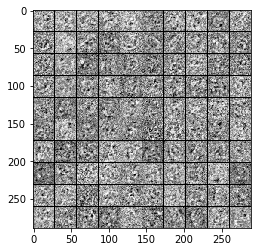

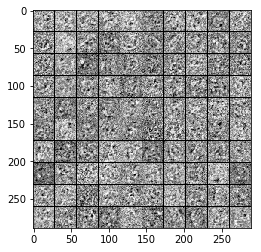

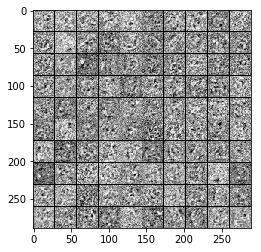

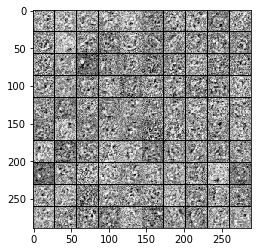

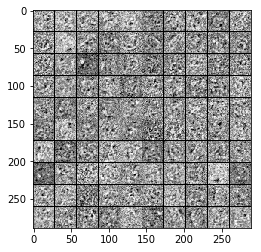

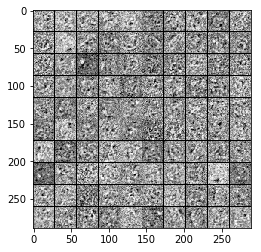

In [4]:
batch_size = 100
num_train_batch = old_div(dat.shape[0], batch_size)
for epoch in range(10):
    w.to_host()  # move the tensor to the host to get its values
    wnp = tensor.to_numpy(w)
    image = Image.fromarray(utils.tile_raster_images(X = wnp.T, img_shape=(28, 28), 
                                                     tile_shape=(10, 10), tile_spacing=(1,1)))

    plt.figure()
    plt.imshow(image, cmap='Greys_r')

    err = 0.0
    w.to_device(dev) # move the tensor back to the device    
    tposhidrandom = tensor.Tensor((batch_size, hdim), dev)
    for b in range(num_train_batch):
        # positive phase
        tdata = tensor.from_numpy(dat[(b * batch_size):((b + 1) * batch_size), : ])
        tdata.to_device(dev)
        tposhidprob = tensor.mult(tdata, w)
        tposhidprob.add_row(hb)
        tposhidprob = tensor.sigmoid(tposhidprob)        
        tposhidrandom.uniform(0.0, 1.0)
        tposhidsample = tensor.gt(tposhidprob, tposhidrandom)

        # negative phase
        tnegdata = tensor.mult(tposhidsample, w.T())
        tnegdata.add_row(vb)
        tnegdata = tensor.sigmoid(tnegdata)
        tneghidprob = tensor.mult(tnegdata, w)
        tneghidprob.add_row(hb)
        tneghidprob = tensor.sigmoid(tneghidprob)
        
        err += tensor.sum(tensor.square((tdata - tnegdata)))
        # compute gradients
        gw = tensor.mult(tnegdata.T(), tneghidprob) - tensor.mult(tdata.T(), tposhidprob)
        gvb = tensor.sum(tnegdata, 0) - tensor.sum(tdata, 0)
        ghb = tensor.sum(tneghidprob, 0) - tensor.sum(tposhidprob, 0)

        # update parameters
        opt.apply_with_lr(epoch, old_div(0.01, batch_size), gw, w, 'w')
        opt.apply_with_lr(epoch, old_div(0.01, batch_size), gvb, vb, 'vb')
        opt.apply_with_lr(epoch, old_div(0.01, batch_size), ghb, hb, 'hb')

    print('Epoch %d, Reconstruction error per image = %f' % (epoch, err / num_train_batch / batch_size))

## Observation

We can see that the reconstruction error is decreasing and the gabor filters in the figures of the weight matrix is becoming clearer.